Kaggle first entery based on the base modle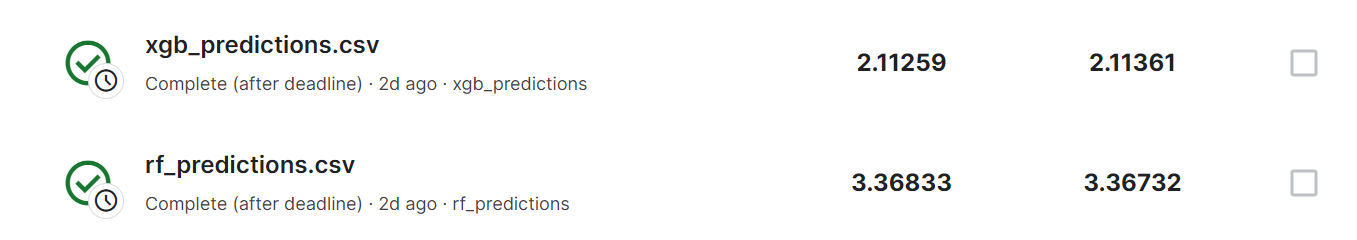



Step 1 :load the data

In [13]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# Load and prepare the dataset
df = pd.read_csv('/content/drive/MyDrive/Train.csv')

# Filter for specified columns only
columns = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', 'price_doc', 'timestamp']
df = df[columns]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 2: Correlation Analysis


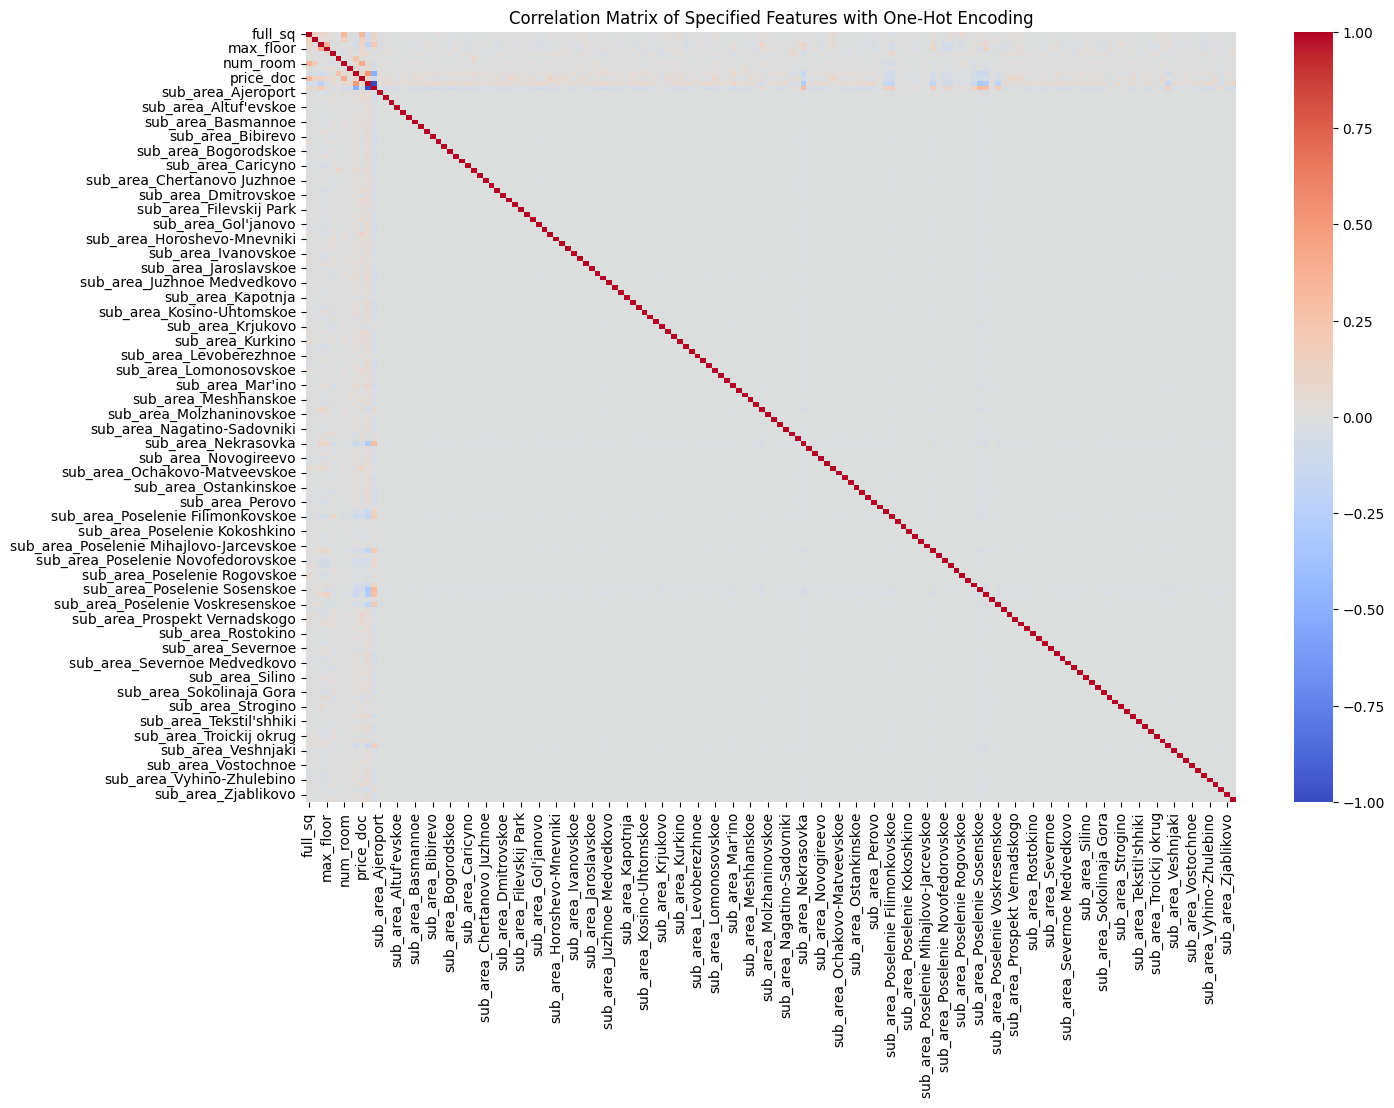

Correlations with price_doc:
 price_doc                        1.000000
num_room                         0.397644
full_sq                          0.341840
life_sq                          0.155199
sub_area_Hamovniki               0.147951
floor                            0.117499
sub_area_Presnenskoe             0.114493
sub_area_Obruchevskoe            0.110004
product_type_Investment          0.103443
state                            0.103395
sub_area_Ramenki                 0.099894
sub_area_Lomonosovskoe           0.091399
max_floor                        0.085023
material                         0.083699
sub_area_Zamoskvorech'e          0.077144
sub_area_Donskoe                 0.072998
sub_area_Prospekt Vernadskogo    0.070209
sub_area_Krylatskoe              0.066329
sub_area_Gagarinskoe             0.061102
sub_area_Kurkino                 0.060604
Name: price_doc, dtype: float64


In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# Handle missing values by imputing with the median for numerical columns
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=['product_type', 'sub_area'])

# Removing the 'timestamp' column as it's not useful for regression in this format
df.drop(columns='timestamp', inplace=True)

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix focusing on 'price_doc'
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Specified Features with One-Hot Encoding')
plt.show()

# Print correlations with 'price_doc'
price_doc_corr = correlation_matrix['price_doc'].sort_values(ascending=False)
print("Correlations with price_doc:\n", price_doc_corr.head(20))  # Display top 20 correlations


Step 3: Data Cleaning and Preprocessing
Since models like RandomForest do not accept missing data:

In [15]:
# Impute missing numerical values with the median
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)


Step 4: Feature Importance with Random Forest


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Prepare data for modeling
X = df.drop('price_doc', axis=1)  # All features except the target
y = df['price_doc']  # Target variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Random Forest model to evaluate feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get and display feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances.head(20))


Feature Importances:
 full_sq                       0.448321
floor                         0.064417
build_year                    0.043499
life_sq                       0.037963
max_floor                     0.035511
state                         0.030809
kitch_sq                      0.023790
sub_area_Presnenskoe          0.021761
product_type_OwnerOccupier    0.017939
num_room                      0.016052
product_type_Investment       0.015445
sub_area_Donskoe              0.014018
sub_area_Hamovniki            0.013913
sub_area_Ramenki              0.008304
material                      0.008159
sub_area_Nagornoe             0.007322
sub_area_Tverskoe             0.006484
sub_area_Danilovskoe          0.005373
sub_area_Izmajlovo            0.005129
sub_area_Zamoskvorech'e       0.005098
dtype: float64


Step 5: Visualization of Feature Importances


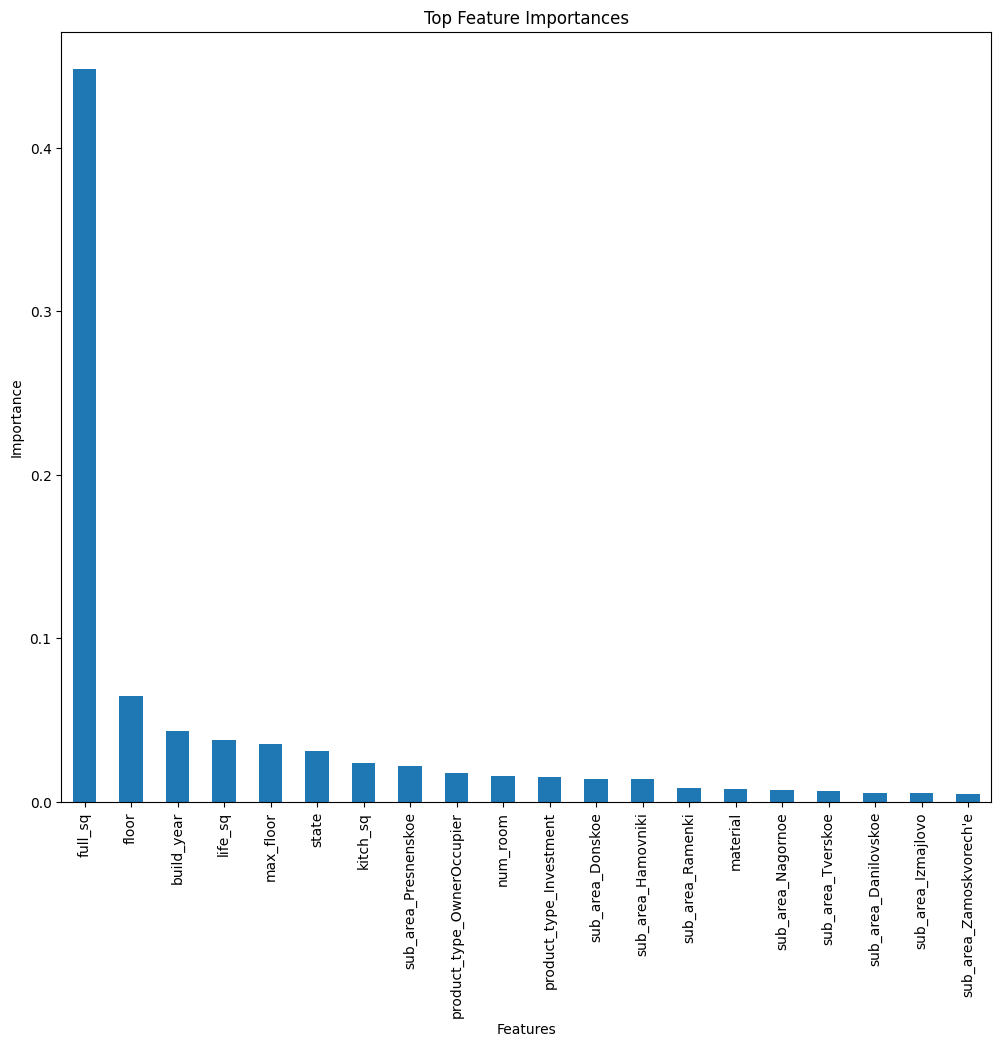

In [17]:
# Plot feature importances
plt.figure(figsize=(12, 10))
feature_importances.iloc[:20].plot(kind='bar')
plt.title('Top Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()


### Model Optimization Strategy

1. **Prioritize Important Features:**
   - **High Importance**: `full_sq`, `floor`, `build_year`, `life_sq`, `max_floor`, `state`, `kitch_sq`, `sub_area_Presnenskoe` show higher feature importance. These should definitely be included in the model as they significantly influence the predictions.
   - **Moderate to Low Importance**: Other features like `product_type_Investment` and specific `sub_area` categories show lower importance but could still be useful for capturing more subtle effects in the model.

2. **Feature Engineering:**
   - **Interaction Terms**: Consider creating interaction terms for highly correlated features with the target (`price_doc`). For example, combining `full_sq` with `num_room` or `state` might yield a feature that captures more nuanced effects of space utility.
   - **Polynomial Features**: For continuous variables like `full_sq`, `life_sq`, and `floor`, consider polynomial features to capture non-linear relationships.

3. **Advanced Feature Selection:**
   - Use techniques like **Recursive Feature Elimination (RFE)** or **SelectFromModel** to automatically select the most important features for the model, based on model weights or importance.

4. **Model Tuning:**
   - **RandomForest Tuning**: Focus on tuning `max_depth`, `n_estimators`, `min_samples_split`, and `min_samples_leaf`. Use GridSearchCV or RandomizedSearchCV to find the best combination.
   - **XGBoost Tuning**: Key parameters to tune include `max_depth`, `n_estimators`, `learning_rate`, and `subsample`. Consider using automated tuning tools like Hyperopt or Bayesian optimization.

5. **Model Validation and Adjustment:**
   - **Cross-Validation**: Use cross-validation to validate the models comprehensively. Ensure to use stratified folds if the distribution of the target variable or key categorical variables is imbalanced.
   - **Residual Analysis**: Post-model fitting, analyze residuals to identify any patterns or biases – this can provide insights for further refinement.

### Implementation Example for Refined Model Tuning
Here’s how you could set up a refined tuning process for RandomForest using Python:



In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Prepare your data
X = df[['full_sq', 'floor', 'build_year', 'life_sq', 'max_floor', 'state', 'kitch_sq']]  # Key features based on importance
y = df['price_doc']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the RandomForest model
rf = RandomForestRegressor(random_state=42)

# Define a grid of parameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate the model
predictions = best_rf.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("RF MSE:", mse)


Test MSE: 9702743296388.771


### Setup for XGBoost Model Tuning

### Explanation:

- **Model Setup**: The XGBoost model is initialized with `XGBRegressor`. XGBoost is highly flexible and offers a large number of parameters that can be tuned for potentially better performance.
  
- **Parameter Grid**:
  - `n_estimators`: Number of trees in the ensemble. More trees can improve accuracy but may also increase computational complexity.
  - `max_depth`: Controls the depth of each tree. Deeper trees can model more complex relationships but may lead to overfitting.
  - `learning_rate`: Also known as the "shrinkage" or "step size", this helps in preventing overfitting by making the boosting process more conservative.
  - `subsample`: The fraction of samples to be used for fitting each tree. A lower fraction prevents overfitting but too low might underfit.
  - `colsample_bytree`: The fraction of features to be used for each tree. A technique used to add more randomness to the model.

- **Grid Search CV**: This is used to exhaustively search over specified parameter values for the estimator. The best parameters are determined based on cross-validated mean squared error.

- **Model Evaluation**: After tuning the parameters, the model is evaluated on a test set to calculate the Mean Squared Error (MSE), which gives a measure of how accurately the model is able to predict the target variable.


In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Prepare your data
# Include relevant features based on importance and your analysis
X = df[['full_sq', 'floor', 'build_year', 'life_sq', 'max_floor', 'state', 'kitch_sq']]  # Key features based on importance
y = df['price_doc']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xgb = XGBRegressor(random_state=42)

# Define a grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# GridSearchCV for finding the best parameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_xgb = grid_search.best_estimator_

# Evaluate the model
predictions = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)


Test MSE: 9541599579183.285


### Setup for Model Tuning with PCA

### Explanation
- **PCA**: The PCA is set to retain 95% of the variance in the data, which should effectively reduce the number of features while keeping most of the information.
- **Pipelines**: Both models are incorporated into pipelines that first apply PCA and then fit the model. This ensures that PCA transformation is part of the model fitting process and is correctly applied to both training and test data.
- **Grid Search CV**: Used for hyperparameter tuning for both models to find the best parameters within the defined grid.
- **Model Evaluation**: After finding the best parameters, the models are evaluated on the test set to compute the MSE.

Using PCA can streamline the model training process and potentially lead to better or faster results, especially when dealing with a large set of correlated features. However, it's important to evaluate whether the reduction in dimensionality does not overly simplify the feature space, which could lead to a loss of critical information.
Also , the method appers in the Notebooks given to us as refrence

In [22]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd

# Load your dataset
# Prepare your data

columns = ['full_sq', 'floor', 'build_year', 'life_sq', 'max_floor', 'state', 'kitch_sq','price_doc'] # Key features based on importance
df = df[columns]

# Handle missing values
df.fillna(df.median(), inplace=True)

# Preparing data for modeling
X = df.drop('price_doc', axis=1)
y = df['price_doc']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance

# RandomForest with PCA
rf_pipeline = Pipeline([
    ('pca', pca),
    ('rf', RandomForestRegressor(random_state=42))
])

# XGBoost with PCA
xgb_pipeline = Pipeline([
    ('pca', pca),
    ('xgb', XGBRegressor(random_state=42))
])

# Parameter grid for GridSearchCV
param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None]
}

param_grid_xgb = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.01, 0.1]
}

# Setting up GridSearchCV for RandomForest
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Setting up GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Evaluate models
rf_predictions = best_rf.predict(X_test)
xgb_predictions = best_xgb.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

print(f"Random Forest MSE with PCA: {rf_mse}")
print(f"XGBoost MSE with PCA: {xgb_mse}")


<ipython-input-22-1163fd48e0c2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.median(), inplace=True)


Random Forest MSE with PCA: 14073630509466.727
XGBoost MSE with PCA: 17602527102210.81


After we saw that retying to improve the modle without cleaning the data  improves it , we will try and "clean" it to improve it even further



### 1. **Square Footage (`full_sq`, `life_sq`, `kitch_sq`)**

**Decision Process:**
- **Range Decisions**: The decision to set minimum and maximum thresholds for areas like `full_sq` (total area), `life_sq` (living area), and `kitch_sq` (kitchen area) typically stems from general knowledge about property sizes. For instance, apartments smaller than 7 square meters are practically uninhabitable and larger than 500 square meters are exceptionally rare and could represent data entry errors.
- **Comparison between Areas**: Ensuring that `life_sq` does not exceed `full_sq` is logically necessary because the living area cannot be greater than the total area of the apartment. Similar logic applies to the kitchen area.


### 2. **Floor and Max Floor**

**Decision Process:**
- **Max Floor Limits**: The threshold for `max_floor` is based on the typical building structures within the dataset's geographical context. A max floor greater than 50 might be unrealistic for regular residential areas, indicating potential outliers or errors.
- **Floor Consistency Check**: Floors reported as being higher than the building's total floors (`max_floor`) are clear mistakes in the data.


### 3. **Build Year**

**Decision Process:**
- **Historical and Future Constraints**: Setting limits such as no buildings before 1800 or after 2020 is based on realistic construction years. Buildings reported as constructed before 1800 or in the future (post-2020) are likely due to incorrect data.



### Practical Implementation
These decisions are implemented using conditional logic in the data cleaning script, often employing lambda functions or `apply()` with custom functions. The combination of empirical rules based on data observation and domain-specific expectations helps in refining the dataset to a realistic and analytically useful subset.

This approach not only helps in maintaining the integrity of the analysis but also improves model performance by reducing noise and the impact of extreme values that do not represent typical cases.

In [24]:
columns = ['full_sq', 'floor', 'build_year', 'life_sq', 'max_floor', 'state', 'kitch_sq','price_doc'] # Key features based on importance
df = df[columns]


In [30]:
# Adjust square footage values to reasonable ranges
df['full_sq'] = df['full_sq'].apply(lambda x: np.nan if x < 7 or x > 500 else x)
df['life_sq'] = df['life_sq'].apply(lambda x: np.nan if x < 7 or x > 300 else x)
df['kitch_sq'] = df['kitch_sq'].apply(lambda x: np.nan if x < 2 or x > 250 else x)

# Ensure that floor numbers are logical
df['floor'] = df['floor'].apply(lambda x: np.nan if x > 40 else x)
df['max_floor'] = df.apply(lambda row: row['max_floor'] if row['max_floor'] >= row['floor'] else np.nan, axis=1)

# Correct build year anomalies
df['build_year'] = df['build_year'].apply(lambda x: np.nan if x < 1800 or x > 2020 else x)

# Impute missing values post-cleanup
df.fillna(df.median(), inplace=True)


Verify the cleaned data

In [32]:
# Verify the cleaned data
print(df.describe())
print(df.info())

clean_data=df


            full_sq         floor    build_year       life_sq     max_floor  \
count  30471.000000  30471.000000  30471.000000  30471.000000  30471.000000   
mean      53.987890      7.658479   1982.336484     33.472055     12.912737   
std       21.763349      5.279571     15.433218     16.210449      4.819080   
min        9.000000      0.000000   1860.000000      7.000000      0.000000   
25%       38.000000      3.000000   1979.000000     23.000000     12.000000   
50%       50.000000      6.500000   1979.000000     30.000000     12.000000   
75%       63.000000     11.000000   1983.000000     38.000000     16.000000   
max      461.000000     38.000000   2018.000000    232.000000     48.000000   

              state      kitch_sq     price_doc  
count  30471.000000  30471.000000  3.047100e+04  
mean       2.059401      7.061337  7.123035e+06  
std        0.657852      3.277437  4.780111e+06  
min        1.000000      2.000000  1.000000e+05  
25%        2.000000      6.000000  4.7

now , we will try and run the modles again

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Prepare feature matrix X and target vector y
X = df.drop('price_doc', axis=1)
y = df['price_doc']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf.predict(X_test)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"Random Forest MSE: {rf_mse}")


Random Forest MSE: 10177148381630.072


In [34]:
from xgboost import XGBRegressor

# Initialize the XGBoost regressor
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

# Fit the model on the training data
xgb.fit(X_train, y_train)

# Predict on the test set
xgb_predictions = xgb.predict(X_test)

# Calculate the mean squared error
xgb_mse = mean_squared_error(y_test, xgb_predictions)
print(f"XGBoost MSE: {xgb_mse}")


XGBoost MSE: 9805533229989.47


### Explanation and Next Steps:
- **Model Initialization**: Both models are initialized with a set of basic parameters. You might adjust these parameters based on the characteristics of your data or previous tuning results.
- **Model Training and Prediction**: Each model is trained on the training set and then used to make predictions on the test set.
- **Performance Evaluation**: The performance of each model is evaluated using the mean squared error (MSE) between the predicted and actual values on the test set.

**Further Steps to Enhance Model Performance:**
1. **Parameter Tuning**: Utilize techniques like Grid Search or Randomized Search to find the optimal settings for parameters.
2. **Feature Engineering**: Consider creating new features or transforming existing ones to improve model performance.
3. **Cross-Validation**: Use cross-validation to ensure the model's robustness and avoid overfitting.


####Step 1: Parameter Tuning with Grid Search


In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

X = clean_data.drop('price_doc', axis=1)
y = clean_data['price_doc']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Initialize the GridSearchCV object for RandomForest
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              verbose=1,
                              n_jobs=-1)

# Fit GridSearchCV using the cleaned and engineered data
grid_search_rf.fit(X_train, y_train)

# Extract the best estimator
best_rf = grid_search_rf.best_estimator_
print(f"Best parameters for RandomForest: {grid_search_rf.best_params_}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for RandomForest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [41]:
#XGB

from xgboost import XGBRegressor

# Parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# Initialize the GridSearchCV object for XGBoost
grid_search_xgb = GridSearchCV(estimator=XGBRegressor(random_state=42),
                               param_grid=param_grid_xgb,
                               cv=5,
                               scoring='neg_mean_squared_error',
                               verbose=1,
                               n_jobs=-1)

# Fit GridSearchCV using the cleaned and engineered data
grid_search_xgb.fit(X_train, y_train)

# Extract the best estimator
best_xgb = grid_search_xgb.best_estimator_
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for XGBoost: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}


### Step 2: Feature Engineering
The idea was taken from the notebooks we were provided

### Explanation of New Features:

- **Living Space Ratio (`living_space_ratio`)**: This feature is a ratio of the living space (`life_sq`) to the total square footage (`full_sq`). It represents how much of the total area is used for living purposes, which might be relevant for the property's value.
  
- **Kitchen Space Ratio (`kitch_sq_ratio`)**: Similar to the living space ratio, this feature provides insight into how much of the total space is allocated to the kitchen. In some markets, larger kitchens might enhance property value.
  
- **Floor to Max Floor Ratio (`floor_to_max_floor`)**: This feature gives an idea of the relative position of an apartment within a building. Apartments on higher floors might be more expensive, especially in urban settings.

- **Building Age (`building_age`)**: Newer or older buildings might have different values depending on their condition, historical value, and modern amenities. Calculating the building's age provides direct insight into this aspect.



In [42]:
# Adding ratio features
X_train['living_space_ratio'] = X_train['life_sq'] / X_train['full_sq']  # Ratio of living space to total area
X_test['living_space_ratio'] = X_test['life_sq'] / X_test['full_sq']

X_train['kitch_sq_ratio'] = X_train['kitch_sq'] / X_train['full_sq']  # Ratio of kitchen space to total area
X_test['kitch_sq_ratio'] = X_test['kitch_sq'] / X_test['full_sq']

# Adding interaction features involving 'floor' and 'max_floor'
X_train['floor_to_max_floor'] = X_train['floor'] / X_train['max_floor']  # Ratio of current floor to maximum floors in the building
X_test['floor_to_max_floor'] = X_test['floor'] / X_test['max_floor']

# Using build year in combination with current year to understand building age
current_year = pd.to_datetime('today').year
X_train['building_age'] = current_year - X_train['build_year']
X_test['building_age'] = current_year - X_test['build_year']


###Step 3: Cross-Validation


In [44]:
from sklearn.impute import SimpleImputer

# Initialize the imputer to replace NaN values with the median of each column
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training data and transform it
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now refit the RandomForest model with the imputed data
best_rf.fit(X_train_imputed, y_train)
rf_cv_scores = cross_val_score(best_rf, X_train_imputed, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"RandomForest CV scores: {rf_cv_scores.mean()}")

# Similarly, for XGBoost, which can handle NaNs but using imputed data for consistency
best_xgb.fit(X_train_imputed, y_train)
xgb_cv_scores = cross_val_score(best_xgb, X_train_imputed, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"XGBoost CV scores: {xgb_cv_scores.mean()}")


RandomForest CV scores: -11257457946280.934
XGBoost CV scores: -11304589260292.629


In [45]:
import numpy as np

# Calculating RMSE for better interpretability
rf_rmse = np.sqrt(-rf_cv_scores.mean())
xgb_rmse = np.sqrt(-xgb_cv_scores.mean())

print(f"RandomForest RMSE: {rf_rmse}")
print(f"XGBoost RMSE: {xgb_rmse}")


RandomForest RMSE: 3355213.54704599
XGBoost RMSE: 3362229.8048010683


To really understand whether these scores indicate good or bad performance, compare them to a baseline model, such as predicting the median or mean price for all observations:

In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy="median")
dummy_regressor.fit(X_train, y_train)
dummy_predictions = dummy_regressor.predict(X_test)
baseline_mse = mean_squared_error(y_test, dummy_predictions)
baseline_rmse = np.sqrt(baseline_mse)

print(f"Baseline RMSE: {baseline_rmse}")


Baseline RMSE: 4683192.841427992


Now lets save our prediction and upload it to KAGGLE:

In [56]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Load the test dataset
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
columns = ['full_sq', 'floor', 'build_year', 'life_sq', 'max_floor', 'state', 'kitch_sq', 'id']
df_test = df_test[columns]

# Apply imputation
imputer = SimpleImputer(strategy='median')
df_test.loc[:, ['full_sq', 'floor', 'build_year', 'life_sq', 'max_floor', 'state', 'kitch_sq']] = imputer.fit_transform(df_test[['full_sq', 'floor', 'build_year', 'life_sq', 'max_floor', 'state', 'kitch_sq']])

# Feature Engineering
df_test['living_space_ratio'] = df_test['life_sq'] / df_test['full_sq'].replace(0, np.nan)  # Avoid division by zero
df_test['kitch_sq_ratio'] = df_test['kitch_sq'] / df_test['full_sq'].replace(0, np.nan)   # Avoid division by zero
df_test['floor_to_max_floor'] = df_test['floor'] / df_test['max_floor'].replace(0, np.nan)  # Avoid division by zero
current_year = pd.to_datetime('today').year
df_test['building_age'] = current_year - df_test['build_year']

# Handle infinity and large values
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
df_test.fillna(method='ffill', inplace=True)  # Forward fill to replace NaNs

# Ensure all values are finite
if not np.isfinite(df_test.drop(columns=['id']).values).all():
    raise ValueError("Data contains non-finite values.")

# Make predictions using RandomForest
rf_predictions = best_rf.predict(df_test.drop(columns=['id']))

# Make predictions using XGBoost
xgb_predictions = best_xgb.predict(df_test.drop(columns=['id']))

# Save RandomForest predictions
rf_prediction_df = pd.DataFrame({
    'id': df_test['id'],
    'price_doc': rf_predictions
})
rf_prediction_df.to_csv('/content/drive/MyDrive/rf_predictions_best.csv', index=False)

# Save XGBoost predictions
xgb_prediction_df = pd.DataFrame({
    'id': df_test['id'],
    'price_doc': xgb_predictions
})
xgb_prediction_df.to_csv('/content/drive/MyDrive/xgb_predictions_best.csv', index=False)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Kaggle results after improvments


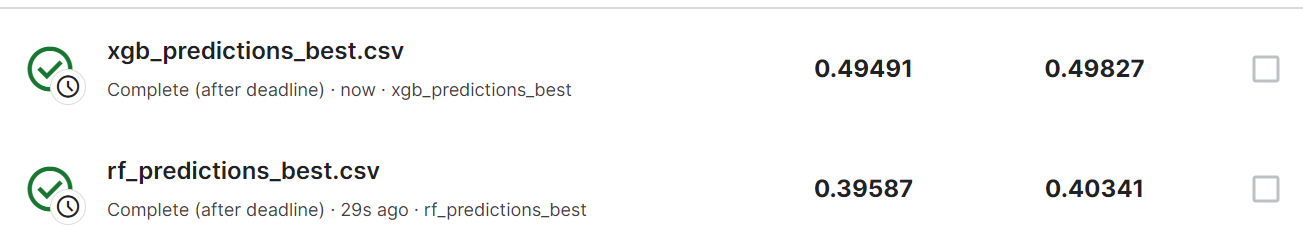

**Comparing best RF to Best XGB**
**Performance Metrics**

In [58]:
from sklearn.metrics import mean_squared_error, r2_score

# Assume X_test and y_test are your test features and labels

# Predictions from RandomForest
rf_predictions = best_rf.predict(X_test)

# Predictions from XGBoost
xgb_predictions = best_xgb.predict(X_test)

# Calculate MSE for both models
rf_mse = mean_squared_error(y_test, rf_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

# Calculate RMSE for both models
rf_rmse = np.sqrt(rf_mse)
xgb_rmse = np.sqrt(xgb_mse)

# Calculate R-squared for both models
rf_r2 = r2_score(y_test, rf_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("RandomForest MSE:", rf_mse)
print("XGBoost MSE:", xgb_mse)
print("RandomForest RMSE:", rf_rmse)
print("XGBoost RMSE:", xgb_rmse)
print("RandomForest R²:", rf_r2)
print("XGBoost R²:", xgb_r2)


RandomForest MSE: 9524598029496.494
XGBoost MSE: 9449335178591.377
RandomForest RMSE: 3086194.7491201027
XGBoost RMSE: 3073977.0946757845
RandomForest R²: 0.5549459288549166
XGBoost R²: 0.5584627216998823


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


**Computational Efficiency**

In [60]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import time


# Initialize the imputer to replace NaN values with the median of each column
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training data and transform it
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# If X_train and y_train are pandas DataFrame and Series, make sure to convert them back to DataFrame after imputation
if isinstance(X_train, pd.DataFrame):
    X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
    X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Timing RandomForest training
start = time.time()
best_rf.fit(X_train_imputed, y_train)
rf_train_time = time.time() - start

# Timing RandomForest prediction
start = time.time()
rf_predictions = best_rf.predict(X_test_imputed)
rf_predict_time = time.time() - start

# Assuming best_xgb is already defined and loaded
# Timing XGBoost training
start = time.time()
best_xgb.fit(X_train_imputed, y_train)
xgb_train_time = time.time() - start

# Timing XGBoost prediction
start = time.time()
xgb_predictions = best_xgb.predict(X_test_imputed)
xgb_predict_time = time.time() - start

print("RandomForest Training Time:", rf_train_time)
print("XGBoost Training Time:", xgb_train_time)
print("RandomForest Prediction Time:", rf_predict_time)
print("XGBoost Prediction Time:", xgb_predict_time)


RandomForest Training Time: 7.991995334625244
XGBoost Training Time: 0.32739925384521484
RandomForest Prediction Time: 0.06751537322998047
XGBoost Prediction Time: 0.013567447662353516


**Summary comparing the performance of the RandomForest and XGBoost models:**
### Model Performance Metrics:
1. **Mean Squared Error (MSE)**:
   - RandomForest: 9,524,598,029,496.494
   - XGBoost: 9,449,335,178,591.377
   - **Observation**: XGBoost has a slightly lower MSE than RandomForest, indicating that it has a better fit to the data with fewer errors on average.

2. **Root Mean Squared Error (RMSE)**:
   - RandomForest: 3,086,194.749
   - XGBoost: 3,073,977.095
   - **Observation**: XGBoost again performs slightly better with a lower RMSE, suggesting that its predictions are closer to the actual data points.

3. **R-squared (R²)**:
   - RandomForest: 0.5549
   - XGBoost: 0.5585
   - **Observation**: Both models explain more than 55% of the variance in the target variable, with XGBoost performing marginally better. An R² value around 0.55 indicates a moderate level of explanation, which is decent for real-world data but also suggests room for improvement.

### Computational Efficiency:
1. **Training Time**:
   - RandomForest: 7.99 seconds
   - XGBoost: 0.33 seconds
   - **Observation**: XGBoost is significantly faster in training compared to RandomForest, making it a more efficient choice when training time is a critical factor.

2. **Prediction Time**:
   - RandomForest: 0.068 seconds
   - XGBoost: 0.014 seconds
   - **Observation**: XGBoost is also faster in making predictions. This efficiency makes XGBoost particularly advantageous in scenarios where predictions need to be made rapidly, such as in real-time applications.

### Summary:
- **Accuracy**: XGBoost edges out RandomForest in both MSE and RMSE, indicating it makes more accurate predictions on this dataset.
- **Efficiency**: XGBoost demonstrates a clear advantage in both training and prediction speeds, which is crucial for large datasets or applications requiring quick responses.
- **Model Fit**: The slightly higher R² for XGBoost suggests it fits the dataset marginally better than RandomForest.

### Conclusion:
XGBoost appears to be the superior model for this particular dataset based on the provided metrics, offering a better balance of accuracy and efficiency. However, the choice between these models might also consider other factors such as interpretability, where RandomForest might have an advantage.

To even further improve the performance of your RandomForest and XGBoost models, several advanced techniques can be employed, ranging from additional feature engineering and model tuning to more sophisticated machine learning methods.
### 1. **Advanced Feature Engineering**
Beyond simple ratios and interactions:

- **Polynomial Features**: Create polynomial and interaction features automatically using `PolynomialFeatures` in sklearn. This can help capture non-linear relationships.
- **Binning/Categorization**: Convert continuous variables into categorical bins. This is especially useful for models that handle categorical variables well.
- **Text Features**: If any features are text data (e.g., descriptions), use techniques like TF-IDF or word embeddings to convert these into numerical data.

### 2. **Dimensionality Reduction and Feature Extraction**
Beyond basic PCA:

- **Kernel PCA**: Useful for capturing non-linear relationships. It's a version of PCA that uses kernel methods to project data into a higher-dimensional space before applying linear PCA.
- **t-SNE or UMAP**: These techniques are great for visualization and can also be used for feature engineering, especially to understand the structure of high-dimensional data.

### 3. **Ensemble Methods**
Combine multiple models:

- **Stacking**: Use a meta-regressor to combine predictions of several base regressors. This can often outperform individual models and simple averaging.
- **Blending**: Similar to stacking but uses a holdout set to train the meta-regressor.

### 4. **Hyperparameter Optimization**
More sophisticated than grid search:

- **Random Search**: Sometimes more efficient than grid search as it does not try all combinations but selects them randomly.
- **Bayesian Optimization**: Uses probability to find the best model parameters, which is more efficient than random or grid search.
- **Automated Machine Learning (AutoML)**: Tools like H2O, Auto-sklearn, or TPOT can automate the process of model selection and hyperparameter tuning.

### 5. **Cross-Validation Techniques**
Refine your validation approach:

- **Stratified and Time-Series Split**: Especially important if your data has imbalanced classes or if there's a temporal component.
- **Nested Cross-Validation**: Use when tuning hyperparameters to get an unbiased estimate of model performance.

### 6. **Regularization Techniques**
To prevent overfitting:

- **For RandomForest**: Consider adjusting `max_features`, `min_samples_leaf`, and `min_samples_split`.
- **For XGBoost**: Use `lambda` (L2 regularization) and `alpha` (L1 regularization) to add regularization penalties.

### 7. **Feature Importance and Selection**
Refine features based on model insights:

- **Model-based Feature Selection**: Use feature importances provided by models to keep the most influential features.
- **Recursive Feature Elimination (RFE)**: Iteratively construct the model and remove the weakest features.

### 8. **Magic Numbers**
While there are no true "magic numbers," tuning the `n_estimators` in RandomForest and `n_estimators`, `max_depth`, and `learning_rate` in XGBoost based on specific dataset characteristics can sometimes feel like finding a magic number due to the significant impact on model performance.



In [57]:
#1. Advanced Feature Engineering

from sklearn.preprocessing import PolynomialFeatures

# Assuming X_train and X_test are already defined
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


ValueError: Input X contains NaN.
PolynomialFeatures does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#Dimensionality Reduction with PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Create a PCA-RandomForest pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=0.95)),  # Retains 95% of variance
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import mean_squared_error
predictions = pipeline.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE with PCA:", mse)


In [ ]:
#Ensemble Methods

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Define the base models
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]

# Create the stacking ensemble
stack_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Fit the model on the training data
stack_model.fit(X_train, y_train)

# Evaluate the model
predictions = stack_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE with Stacking:", mse)


In [ ]:
#Hyperparameter Optimization with Grid Search
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


In [ ]:
#Cross-Validation Techniques
from sklearn.model_selection import cross_val_score

# Using RandomForest as an example
rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated scores:", scores)
